In [1]:
import pandas as pd
import spacy

from sklearn import metrics
import jsonlines

import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.metrics import det_curve

import numpy as np

In [10]:
from spacy.training import Corpus

# doc_bin = DocBin(docs=docs)
# doc_bin.to_disk("./data.spacy")
# reader = Corpus("/home/vs428/project/Incarceration_Data/dev.spacy")
reader = Corpus("/home/vs428/Documents/Incarceration/incarceration_status_binary/dev.spacy")

In [11]:
nlp = spacy.blank("en")
dev_data = reader(nlp)

In [12]:
dev_data = list(dev_data)

In [12]:
dev_data[0].to_dict()['doc_annotation']['cats']

{'On_Probation': 0.0,
 'Current_Incarceration': 0.0,
 'In_Police_Custody': 0.0,
 'Arrested': 0.0,
 'Brought_in_by_Police': 0.0,
 'Family_History_Incarceration': 0.0,
 'Prior_History_Incarceration': 0.0,
 'Recent_Incarceration': 0.0}

In [143]:
training_data = [(x.text, x.to_dict()['doc_annotation']['cats']['Prior_History_Incarceration']) for x in dev_data]


In [144]:
nlp = spacy.load("/home/vs428/Documents/Incarceration/incarceration_model_binary_v2/model-best")

In [145]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'textcat_multilabel']

In [146]:
hx_incarceration = []

with nlp.select_pipes(enable="textcat_multilabel"):
    for doc in nlp.pipe([x for x,y in training_data]):
        hx_incarceration.append(doc.cats['Prior_History_Incarceration'])
        
    


In [147]:

gold_labels = [y for x,y in training_data]

In [148]:
hx_incarceration

[3.1297483928938163e-06,
 0.9988429546356201,
 1.0,
 0.9999251365661621,
 0.9986529350280762,
 0.4939163327217102,
 0.7215203046798706,
 0.29109951853752136,
 0.9998595714569092,
 0.9998816251754761,
 2.8280908736633137e-05,
 0.02922949567437172,
 0.997273862361908,
 0.004102278500795364,
 1.6144271342000138e-07,
 0.5586332082748413,
 2.505564111743297e-08,
 0.9986422657966614,
 0.06382706016302109,
 0.9874312877655029,
 0.011033793911337852,
 0.9020252823829651,
 0.08799579739570618,
 0.9999997615814209,
 0.00022288064064923674,
 0.0389668308198452,
 2.9351174816838466e-05,
 0.03284047544002533,
 0.21468065679073334,
 0.9983853101730347,
 0.005167471244931221,
 0.08245459944009781,
 2.841736659320304e-06,
 0.001421998837031424,
 0.0927511528134346,
 0.03819849342107773,
 0.013399327173829079,
 0.9782895445823669,
 0.005512754898518324,
 0.9989377856254578,
 0.9999947547912598,
 0.9991027116775513,
 0.003257123054936528,
 0.011101379990577698,
 0.0039436100050807,
 0.9998855590820312,


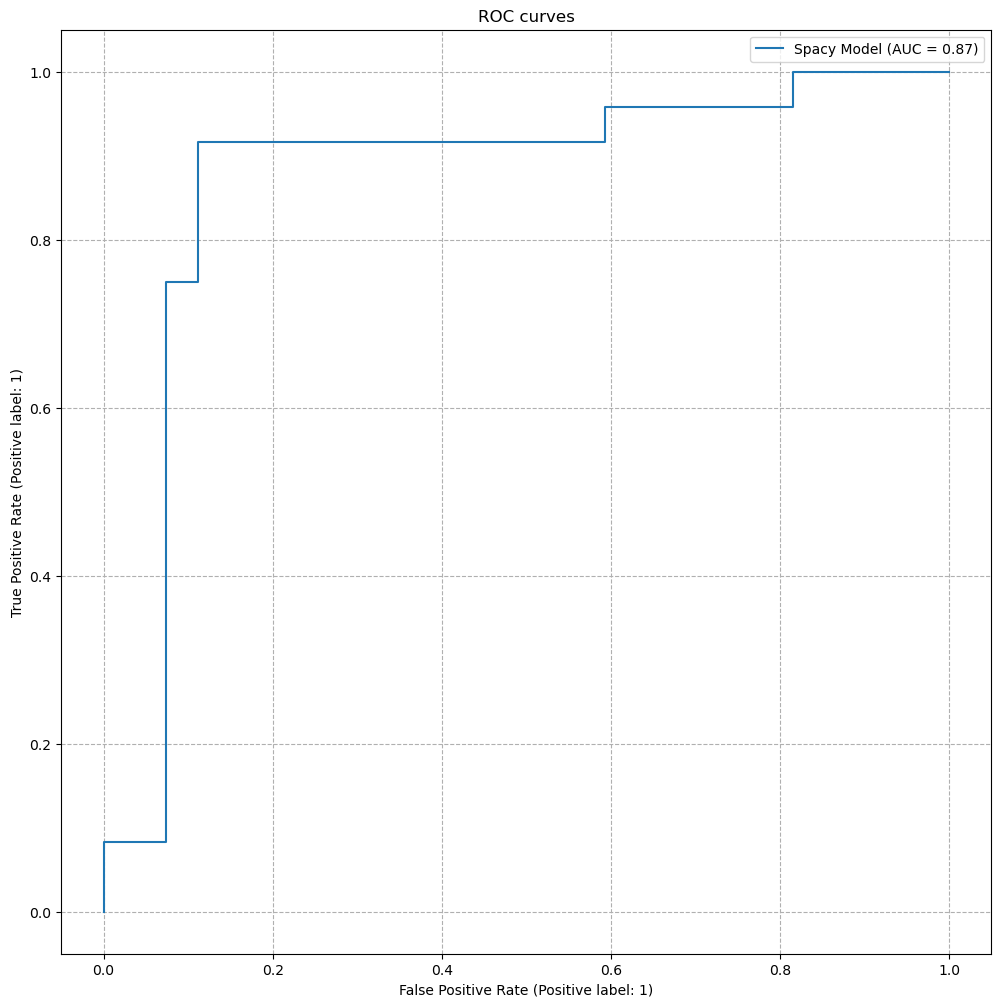

In [149]:
fig, ax = plt.subplots(figsize=(12,12))
RocCurveDisplay.from_predictions(gold_labels, hx_incarceration, ax=ax, name="Spacy Model")

ax.set_title("ROC curves")
ax.grid(linestyle="--")

plt.legend()
plt.show()

In [191]:
from sklearn.metrics import classification_report
classification_report(gold_labels, [True if x > 0.856224000453949 else False for x in hx_incarceration], output_dict=True)

{'0.0': {'precision': 0.78125,
  'recall': 0.9259259259259259,
  'f1-score': 0.847457627118644,
  'support': 27},
 '1.0': {'precision': 0.8947368421052632,
  'recall': 0.7083333333333334,
  'f1-score': 0.7906976744186046,
  'support': 24},
 'accuracy': 0.8235294117647058,
 'macro avg': {'precision': 0.8379934210526316,
  'recall': 0.8171296296296297,
  'f1-score': 0.8190776507686244,
  'support': 51},
 'weighted avg': {'precision': 0.8346555727554179,
  'recall': 0.8235294117647058,
  'f1-score': 0.8207470611421548,
  'support': 51}}

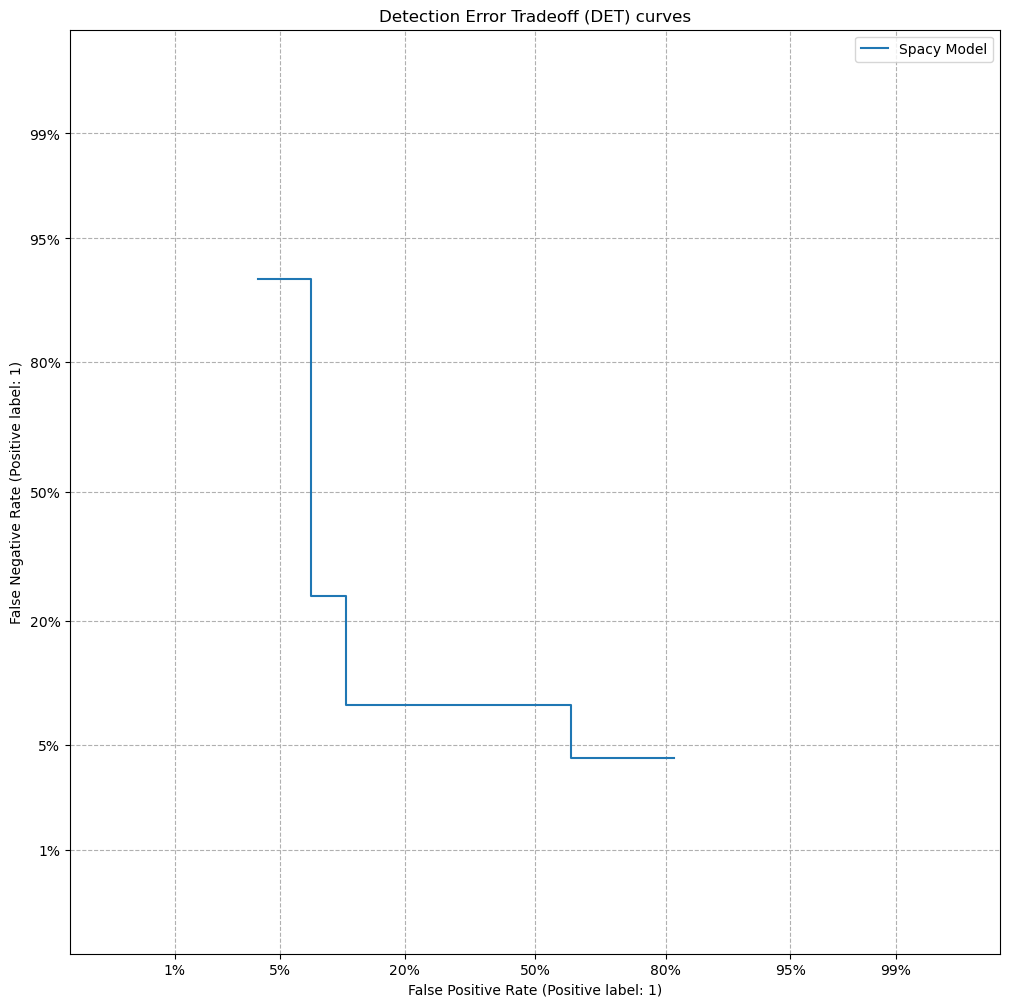

In [224]:
fig, ax = plt.subplots(figsize=(12,12))
DetCurveDisplay.from_predictions(gold_labels, hx_incarceration, ax=ax, name="Spacy Model")

ax.set_title("Detection Error Tradeoff (DET) curves")
ax.grid(linestyle="--")

plt.legend()
plt.show()

In [151]:

fpr, fnr, thresholds = det_curve(gold_labels, hx_incarceration)


In [152]:
np.argmax(thresholds>0.52650887)

24

In [219]:
IDX = 31

In [220]:
thresholds[IDX]

0.997273862361908

In [221]:
fnr[IDX], fpr[IDX]

(0.4583333333333333, 0.07407407407407407)

In [222]:
np.argmax(fpr[::-1]>0.18)
# fpr

25

# Inference on Full Dataset

In [2]:
data = pd.read_csv("/home/vs428/project/Incarceration_Data/ed_notes_19_20.tsv", 
                   sep="\t",
                   on_bad_lines="skip",
                   header=0,
                   engine="python"
                  # quoting=2
                  )

In [3]:
data['person_id'].nunique()


84000

In [4]:
test = data.sample(20)

In [17]:
hx_incarceration = []
with nlp.select_pipes(enable="textcat_multilabel"):
    for idx, doc in enumerate(nlp.pipe(test['TEXT'].astype(str).tolist(), 
                        # disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"],
                        n_process=4
                       )):
        if idx % 100 == 0:
            print(idx)
        # Do something with the doc here
        hx_incarceration.append(doc.cats['Prior_History_Incarceration'])


0


In [18]:
THRESHOLD = 0.627554178237915

In [19]:
test['hx_incarceration_nlp_score'] = hx_incarceration

In [20]:
test[f'hx_incarceration_nlp_pred_{THRESHOLD:.2f}'] = test['hx_incarceration_nlp_score'] > THRESHOLD

In [21]:
test['hx_incarceration_nlp_pred_0.63'].value_counts()

False    18
True      2
Name: hx_incarceration_nlp_pred_0.63, dtype: int64

In [22]:
# test.to_csv("/home/vs428/project/Incarceration_Data/ed_notes_19_20_hx_incarceration_preds.csv", index=False)

In [197]:
test = pd.read_csv("/home/vs428/project/Incarceration_Data/ed_notes_19_20_hx_incarceration_preds.csv")

In [198]:
test.columns

Index(['PAT_ENC_CSN_ID', 'visit_occurrence_id', 'person_id', 'Type', 'TEXT',
       'hx_incarceration_nlp_score', 'hx_incarceration_nlp_pred_0.86'],
      dtype='object')

In [199]:
test['hx_incarceration_nlp_pred_0.86'].value_counts(normalize=True)


False    0.92607
True     0.07393
Name: hx_incarceration_nlp_pred_0.86, dtype: float64

In [175]:
test['regex'] = test['TEXT'].str.contains(r"incarcerated|incarceration")

In [179]:
pd.crosstab(test['hx_incarceration_nlp_pred_0.86'], test['regex'], 
            margins=True,
           normalize=False)


regex,False,True,All
hx_incarceration_nlp_pred_0.86,,,
False,411349,2291,413640
True,31957,1067,33024
All,443306,3358,446664


In [183]:
test[test['hx_incarceration_nlp_pred_0.86']]['person_id'].nunique()

20943

In [200]:
# test = pd.read_csv("/home/vs428/project/Incarceration_Data/test/ed_notes_19_20.tsv", sep="\t")

In [223]:
(test['hx_incarceration_nlp_score'] > 0.99).value_counts()

False    439798
True       6897
Name: hx_incarceration_nlp_score, dtype: int64